# Neural Kalman Filters

A duplicate of "Neural Kalman Filter.ipynb" - for the benchmark const_a instead of free motion (that is, for scenarios without targets turns).

In [1]:
# Auto reload
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import pickle as pkl
from collections import Counter
import gc

import torch
import torch.nn.functional as F

import utils
import TargetSimulator as Sim
import SensorGenerator as Rad
import Trackers
import NeuralTrackers as NT
import TrackingLab as TLAB
import PredictionLab as PLAB

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:90% !important; }</style>"))
np.set_printoptions(precision=3)
np.set_printoptions(linewidth=150)
np.set_printoptions(suppress=True)
torch.set_printoptions(linewidth=150)

# Generate data

In [3]:
ID = 1

### Set configuration

In [21]:
def get_scenario(max_acc=0, n_episodes=1000, n_targets=1, p_vertical=0.3, seed_base=0,
                 old_mode=True, noise=1, far=0, title=None, train=False):
    if title is None:
        title = 'train' if train else 'test'
    seeds = seed_base + np.arange(n_episodes)
    
    return dict(
        targets = dict(
            n_episodes = n_episodes,
            dt = 1,
            old_mode = old_mode,
            acc = max_acc,
            n_targets_args = dict(n1=n_targets-3, n2=n_targets+4) if n_targets>3 else n_targets,
            init_args=dict(t0=10, dt=3, X0=(0,0,0), dx=(4e3,4e3,4e2), V0=(50,0,90), dV=(15,10000,6),
                           unif_x=True, unif_v=False), # dx=(2e3,2e3,1e2)
            n_turns_args = 0,
            line_args = dict(p_acc=0.5, t_mean=30, t_sigma=8, vmax0=150, t_mean_acc=30, t_sigma_acc=8),
            turn_args = dict(p_vertical=p_vertical, p_left=0.5, a_mean=45, a_sigma=270, vertical_fac=0.1),
            seeds = seeds,
            title = title,
        ),
        radar = dict(
            noise_factor = noise,
            FAR = 0,
        )
    )

In [22]:
title = f'benchmark{ID:02d}'
p_vertical = 0.12
a_test = (8,16,32) # (24,48,96)
a_train = (16,)
test_episodes = 100 # 100
train_episodes = 2000 # 4000
n_turns = 3
noise = 1
scenarios  = [get_scenario(a_train, n_episodes=train_episodes, n_targets=1,
                           p_vertical=p_vertical, noise=noise, seed_base=0, train=True)]
scenarios += [get_scenario(a_test, n_episodes=test_episodes, n_targets=20,
                           p_vertical=p_vertical, noise=noise, seed_base=train_episodes)]
scenarios  = {sc['targets']['title']:sc for sc in scenarios}

scenarios.keys()

dict_keys(['train', 'test'])

### Generate

(set `GENERATE=False` to load, `True` to generate)

['train', 'test']
Generating scenario train... done.	(18 [s])
Generating scenario test... done.	(9 [s])
2000 2000 (23, 4) (23, 6) 11.0 70.0 Counter({'08<acc<16': 2000})
CPU times: user 41.2 s, sys: 192 ms, total: 41.4 s
Wall time: 41.3 s


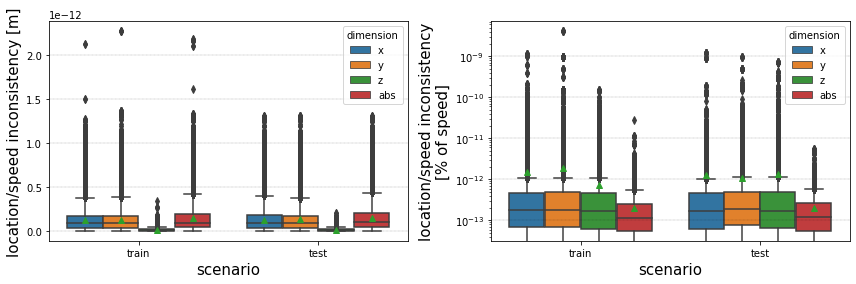

In [24]:
%%time
GENERATE = True
if GENERATE:
    # Generate data
    E = PLAB.create_experiment(scenarios=scenarios, title=title, load=False)
    E.meta_episodes.loc[E.meta_episodes.seed>=(train_episodes), 'group'] = 1
    E.meta_targets.loc[E.meta_targets.seed_ep>=(train_episodes), 'group'] = 1
    E.save_data()
    X, Y, scenarios_train = PLAB.get_group_data(E, 0)
    X2, Y2, scenarios_test = PLAB.get_group_data(E, 1)
    PLAB.save_data(X, Y, scenarios_train, fname=f'train{ID:02d}')
    PLAB.save_data(X2, Y2, scenarios_test, fname=f'test{ID:02d}')
    print(len(X), len(Y), X[0].shape, Y[0].shape, np.min(E.meta_targets['T']), np.max(E.meta_targets['T']), Counter(scenarios_train))

else:
    # just load
    E = PLAB.create_experiment(title=title, load=True)
    X, Y, scenarios_train = PLAB.get_group_data(E, 0)
    X2, Y2, scenarios_test = PLAB.get_group_data(E, 1)
    print(len(X), len(Y), X[0].shape, Y[0].shape, np.min(E.meta_targets['T']), np.max(E.meta_targets['T']), Counter(scenarios_train))

dd = E.targets_consistency_test()

### Load

In [25]:
X,Y,scenarios_train = PLAB.load_data(fname=f'train{ID:02d}')
X2,Y2,scenarios_test = PLAB.load_data(fname=f'test{ID:02d}')

#### Sample target

In [26]:
story, info = E.get_target_story()
print(info)
story

{'max_acc': 32, 'time': 21.0}


phase      mode  time  acc   direct  angle
0      0  straight    22  0.0  forward      0

#### Trajectories lengths

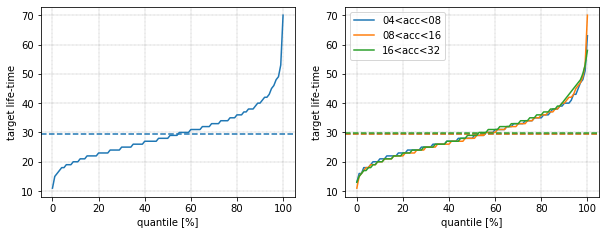

In [27]:
axs = utils.Axes(2)

utils.plot_quantiles(E.meta_targets['T'], plot_mean=True, ax=axs[0])
axs[0].set_xlabel('quantile [%]')
axs[0].set_ylabel('target life-time');

for cls in np.unique(E.meta_targets.target_class):
    utils.plot_quantiles(E.meta_targets[E.meta_targets.target_class==cls]['T'], plot_mean=True, label=cls, ax=axs[1])
axs[1].legend()
axs[1].set_xlabel('quantile [%]')
axs[1].set_ylabel('target life-time');

Text(0, 0.5, 'total time steps in data')

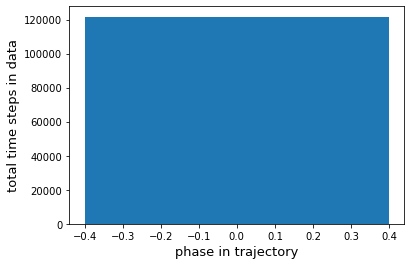

In [28]:
tmp = Counter(pd.concat([tar for sc in E.scenarios for ep in E.targets[sc] for tar in ep]).phase)
plt.bar(tmp.keys(), tmp.values())
plt.xlabel('phase in trajectory', fontsize=13)
plt.ylabel('total time steps in data', fontsize=13)

#### Sample targets

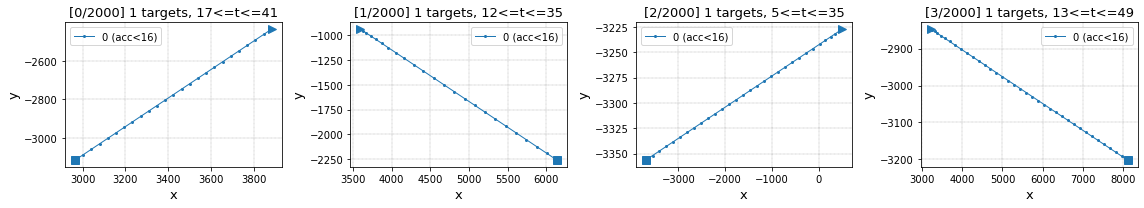

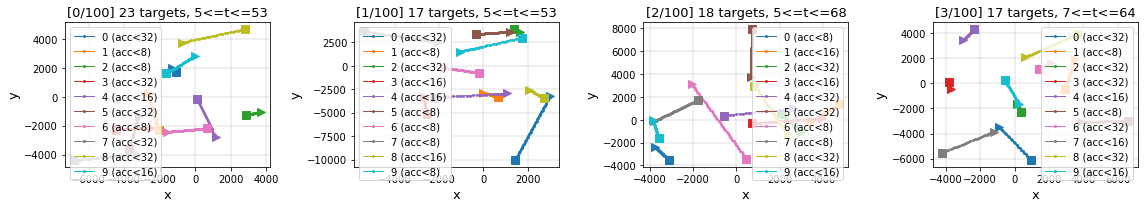

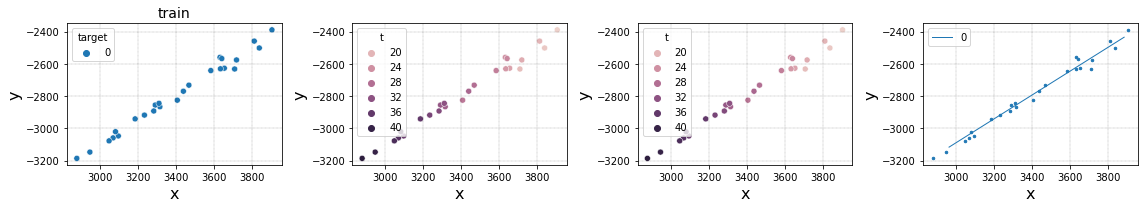

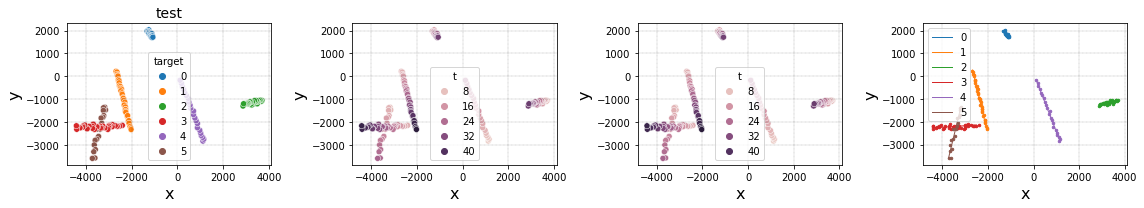

In [29]:
E.show_episodes(episodes_per_scenario=4, max_targets=10)
E.show_detections()

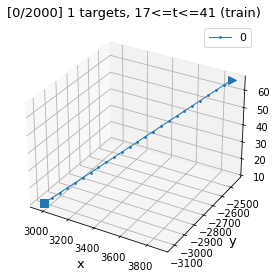

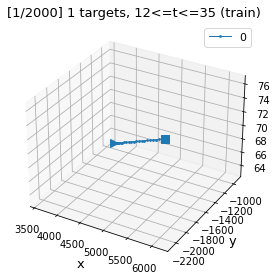

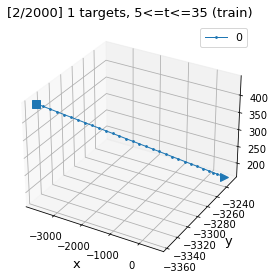

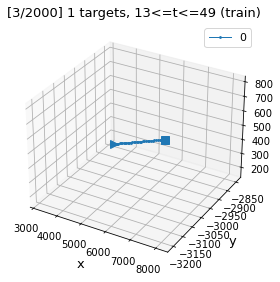

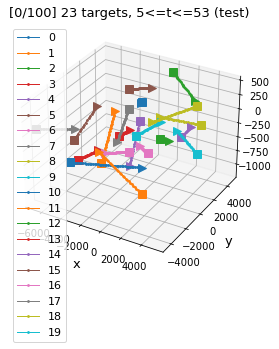

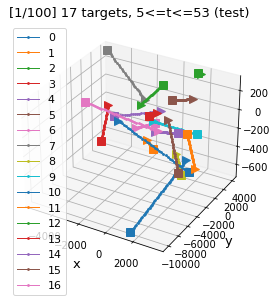

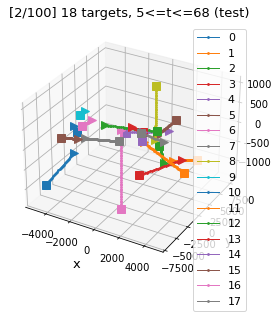

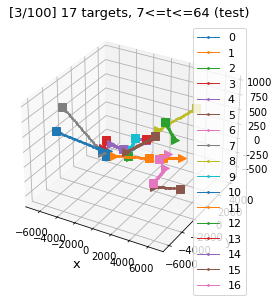

In [30]:
for sc in E.scenarios:
    Sim.show_episodes_3D(E.targets[sc], E.target_args[sc], max_episodes=4, max_targets=20, tit=sc)

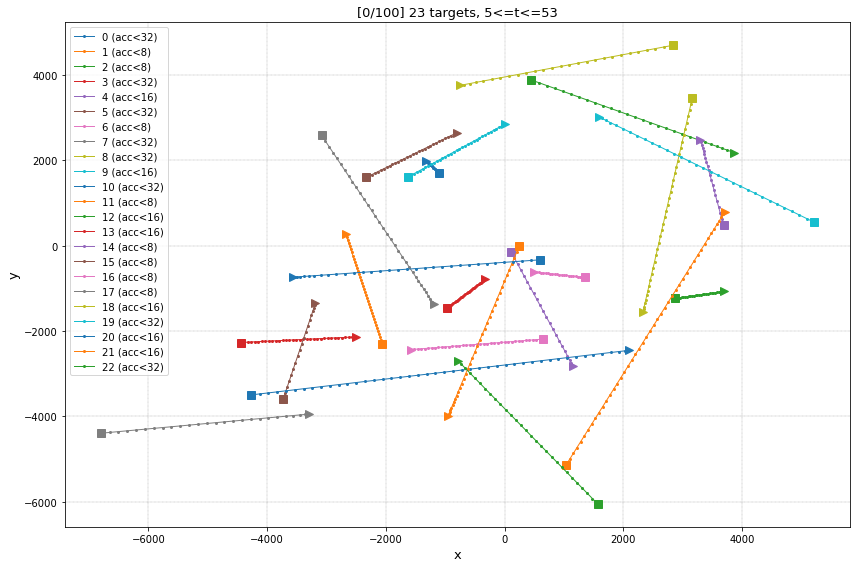

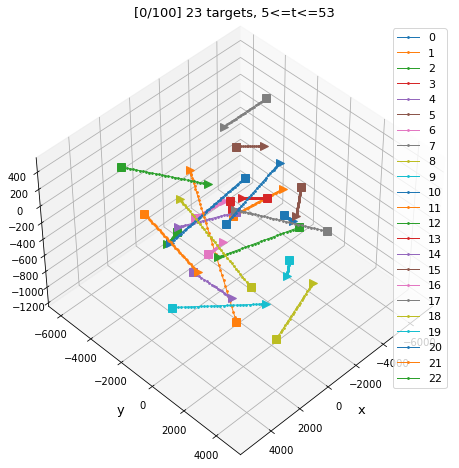

In [31]:
E.show_episodes(scenarios=['test'], episodes_per_scenario=1, max_targets=24, axs=utils.Axes(1,1,axsize=(12,8)))
axs = Sim.show_episodes_3D(E.targets['test'], E.target_args['test'], max_episodes=1, max_targets=24, figsize=(12,8))
axs[0].view_init(45, 45)

# Train models

In [34]:
models_args = [
    dict(load=False, title='KFc', no_acc=True),
    dict(load=False, title='KFp', no_acc=True, polar_R=True),
    dict(load=False, title='OKFc', no_acc=True, const_R=False, const_Q=False),
    dict(load=False, title='OKFp', no_acc=True, const_R=False, const_Q=False, polar_R=True),
    dict(load=False, title='aKFc'),
    dict(load=False, title='aKFp', polar_R=True),
    dict(load=False, title='NKFc', dynamic_Q='nn', dynamic_R=True),
    dict(load=False, title='NKFp', dynamic_Q='nn', dynamic_R=True, polar_R=True),
    dict(load=False, title='NKFHc', dynamic_Q='nn', dynamic_R=True, pred_H=1),
    dict(load=False, title='NKFHp', dynamic_Q='nn', dynamic_R=True, pred_H=1, polar_R=True),
]

gc.collect()

20

Waiting for trainings...
Waiting for processes...
Done.	(12684 [s])
Best validation losses:
	KFc: inf (KFc_s00), inf (KFc_s01)
	KFp: inf (KFp_s00), inf (KFp_s01)
	OKFc: 102 (OKFc_s00), 102 (OKFc_s01)
	OKFp: 100 (OKFp_s01), 100 (OKFp_s00)
	aKFc: 104 (aKFc_s01), 104 (aKFc_s00)
	aKFp: 112 (aKFp_s00), 112 (aKFp_s01)
	NKFc: 103 (NKFc_s01), 102 (NKFc_s00)
	NKFp: 102 (NKFp_s00), 102 (NKFp_s01)
	NKFHc: 96 (NKFHc_s00), 96 (NKFHc_s01)
	NKFHp: 113 (NKFHp_s01), 94 (NKFHp_s00)


/home/ido/code/Using_KF_the_Right_Way/PredictionLab.py:639: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axs[a+0].set_yscale('log')
/home/ido/code/Using_KF_the_Right_Way/PredictionLab.py:642: UserWarning: Attempted to set non-positive top ylim on a log-scaled axis.
Invalid limit will be ignored.
  axs[a+0].set_ylim((None,np.percentile(res[res.group=='train'][y], ylim_quant)))
/home/ido/code/Using_KF_the_Right_Way/utils.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ticks[1])
/home/ido/code/Using_KF_the_Right_Way/utils.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ticks[1])
/home/ido/code/Using_KF_the_Right_Way/utils.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ticks[1])
/home/ido/code/Using_K

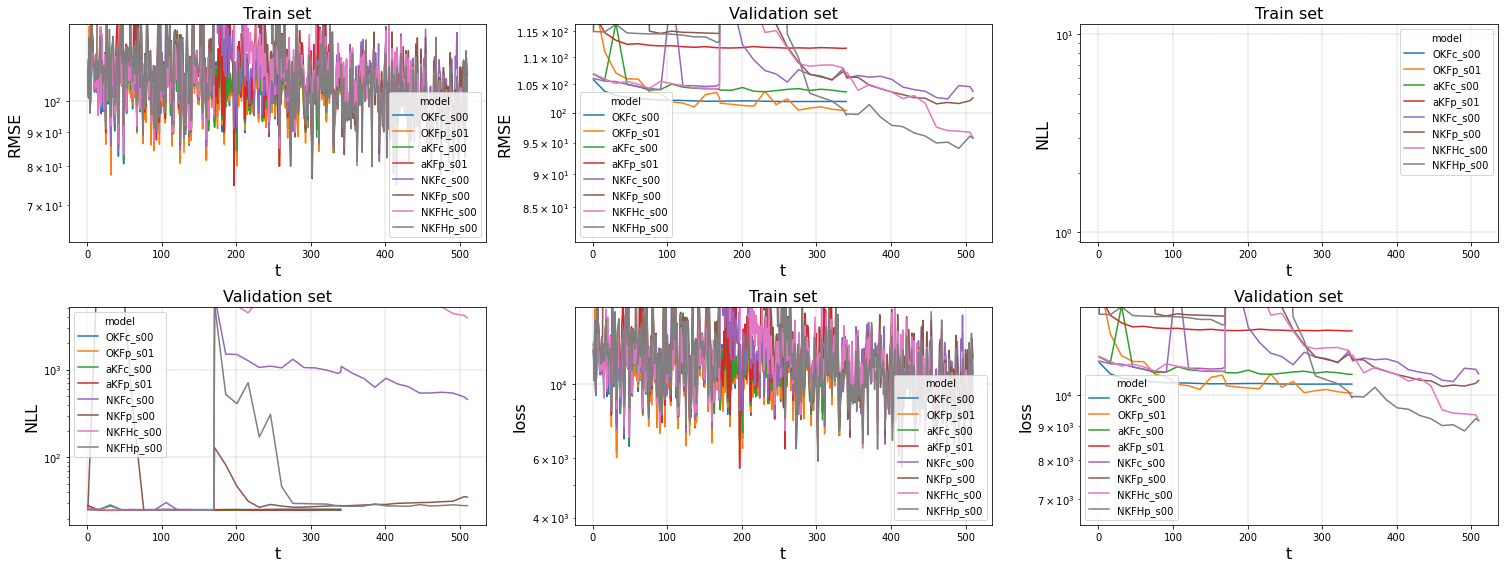

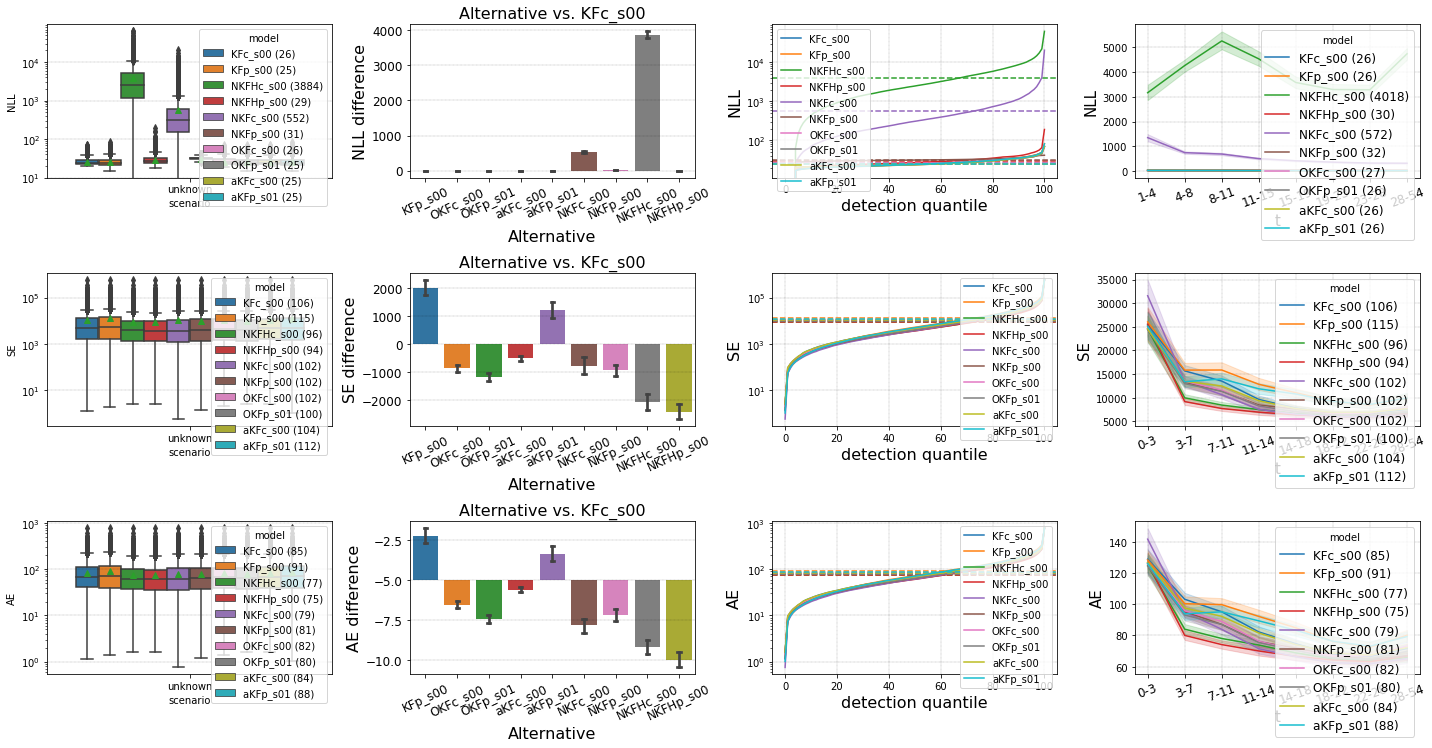

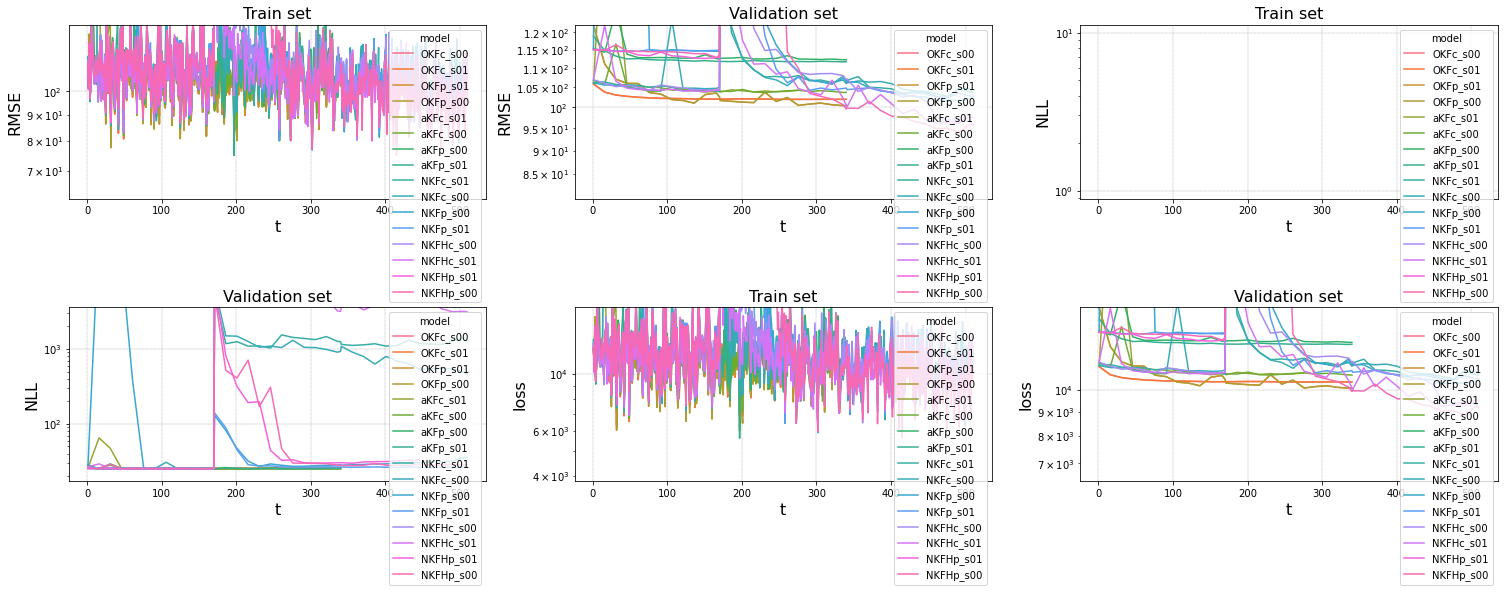

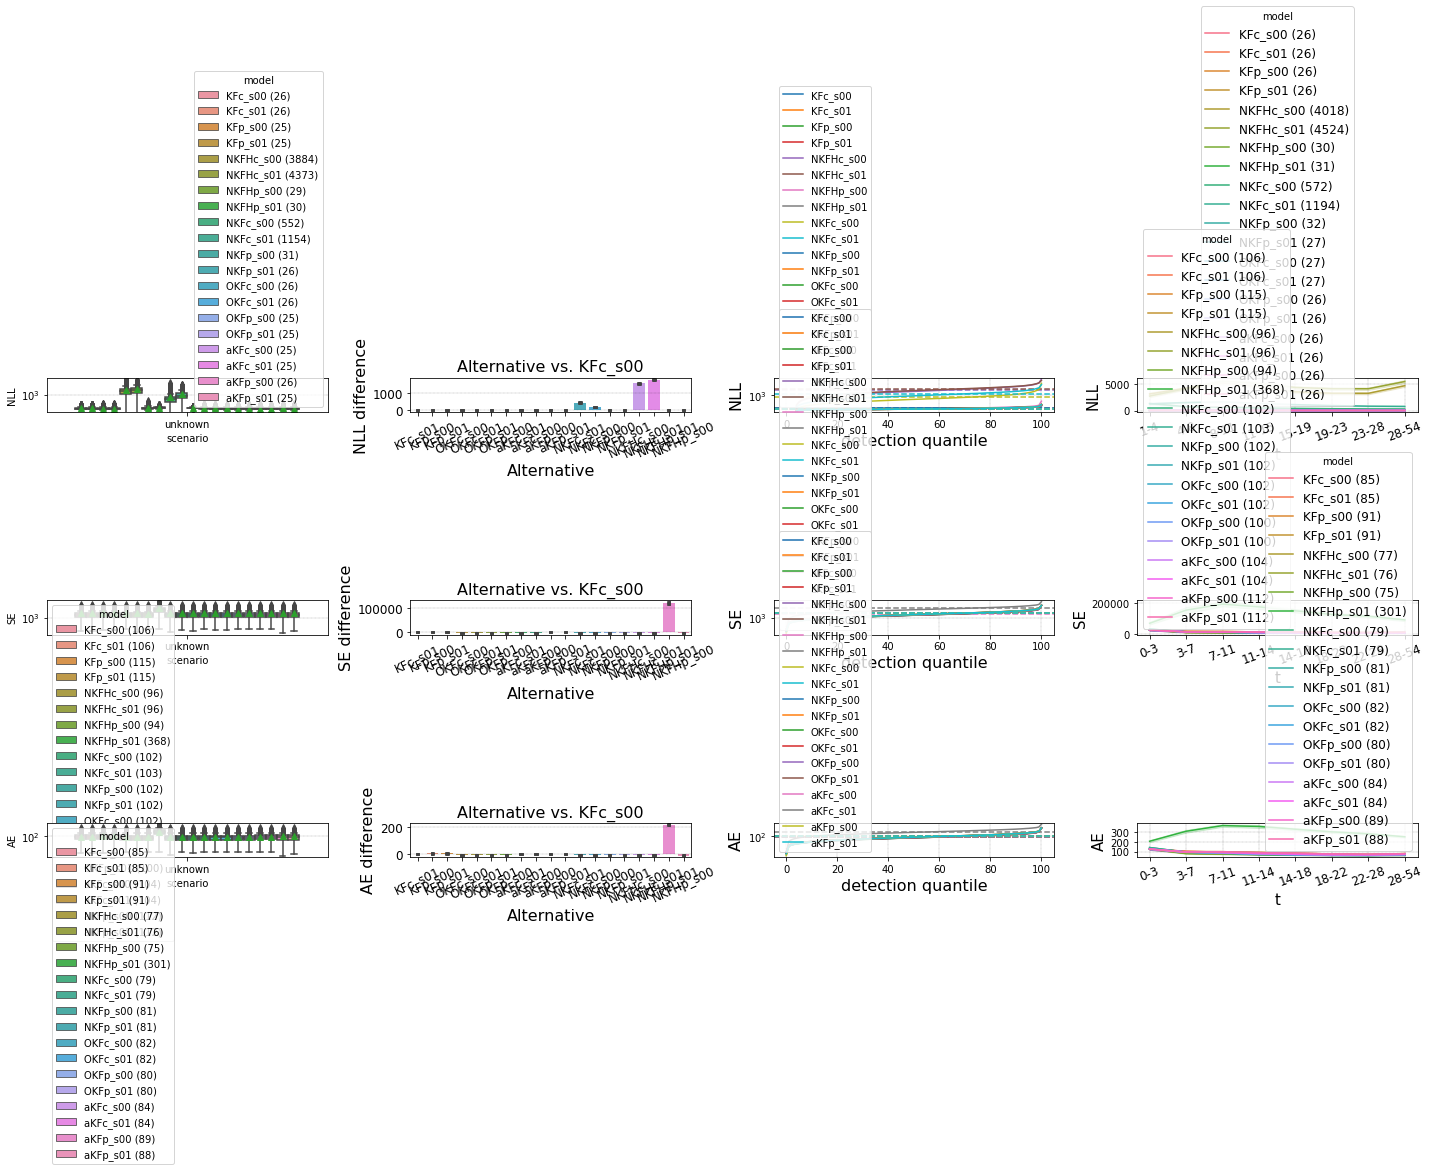

In [35]:
seeds = 2 # train each variant multiple times with different initializations (seeds), and choose the best one according to the validation data

# train
models, train_res, valid_res, ddt, ddv, losses = \
    PLAB.train_models(models_args, X, Y, seeds=seeds, save_res=f'data{ID:02d}', model_fname_prefix=f'data{ID:02d}', n_epochs=2, batch_size=20,
                      tune_phase=True, batch_fac=1, lr_fac=0.5, lr=1e-2, lr_decay=0.5, lr_decay_freq=150, verbose=2)

# show results of chosen models
PLAB.train_summary(train_res, ylim_quant=90);
PLAB.test_analysis(valid_res);

# show results of all models
if seeds > 1:
    PLAB.train_summary(ddt, ylim_quant=90);
    PLAB.test_analysis(ddv);

# Test models

In [36]:
res = PLAB.test_models(models, X2, Y2, scenarios_test)

10 models are split to 2 batches.
Running 20 threads...
Finished models-batch 1/2.	(59 [s])
Running 20 threads...
Finished models-batch 2/2.	(85 [s])


Results for all models:

/home/ido/code/Using_KF_the_Right_Way/utils.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ticks[1])
/home/ido/code/Using_KF_the_Right_Way/utils.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ticks[1])
/home/ido/code/Using_KF_the_Right_Way/utils.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ticks[1])


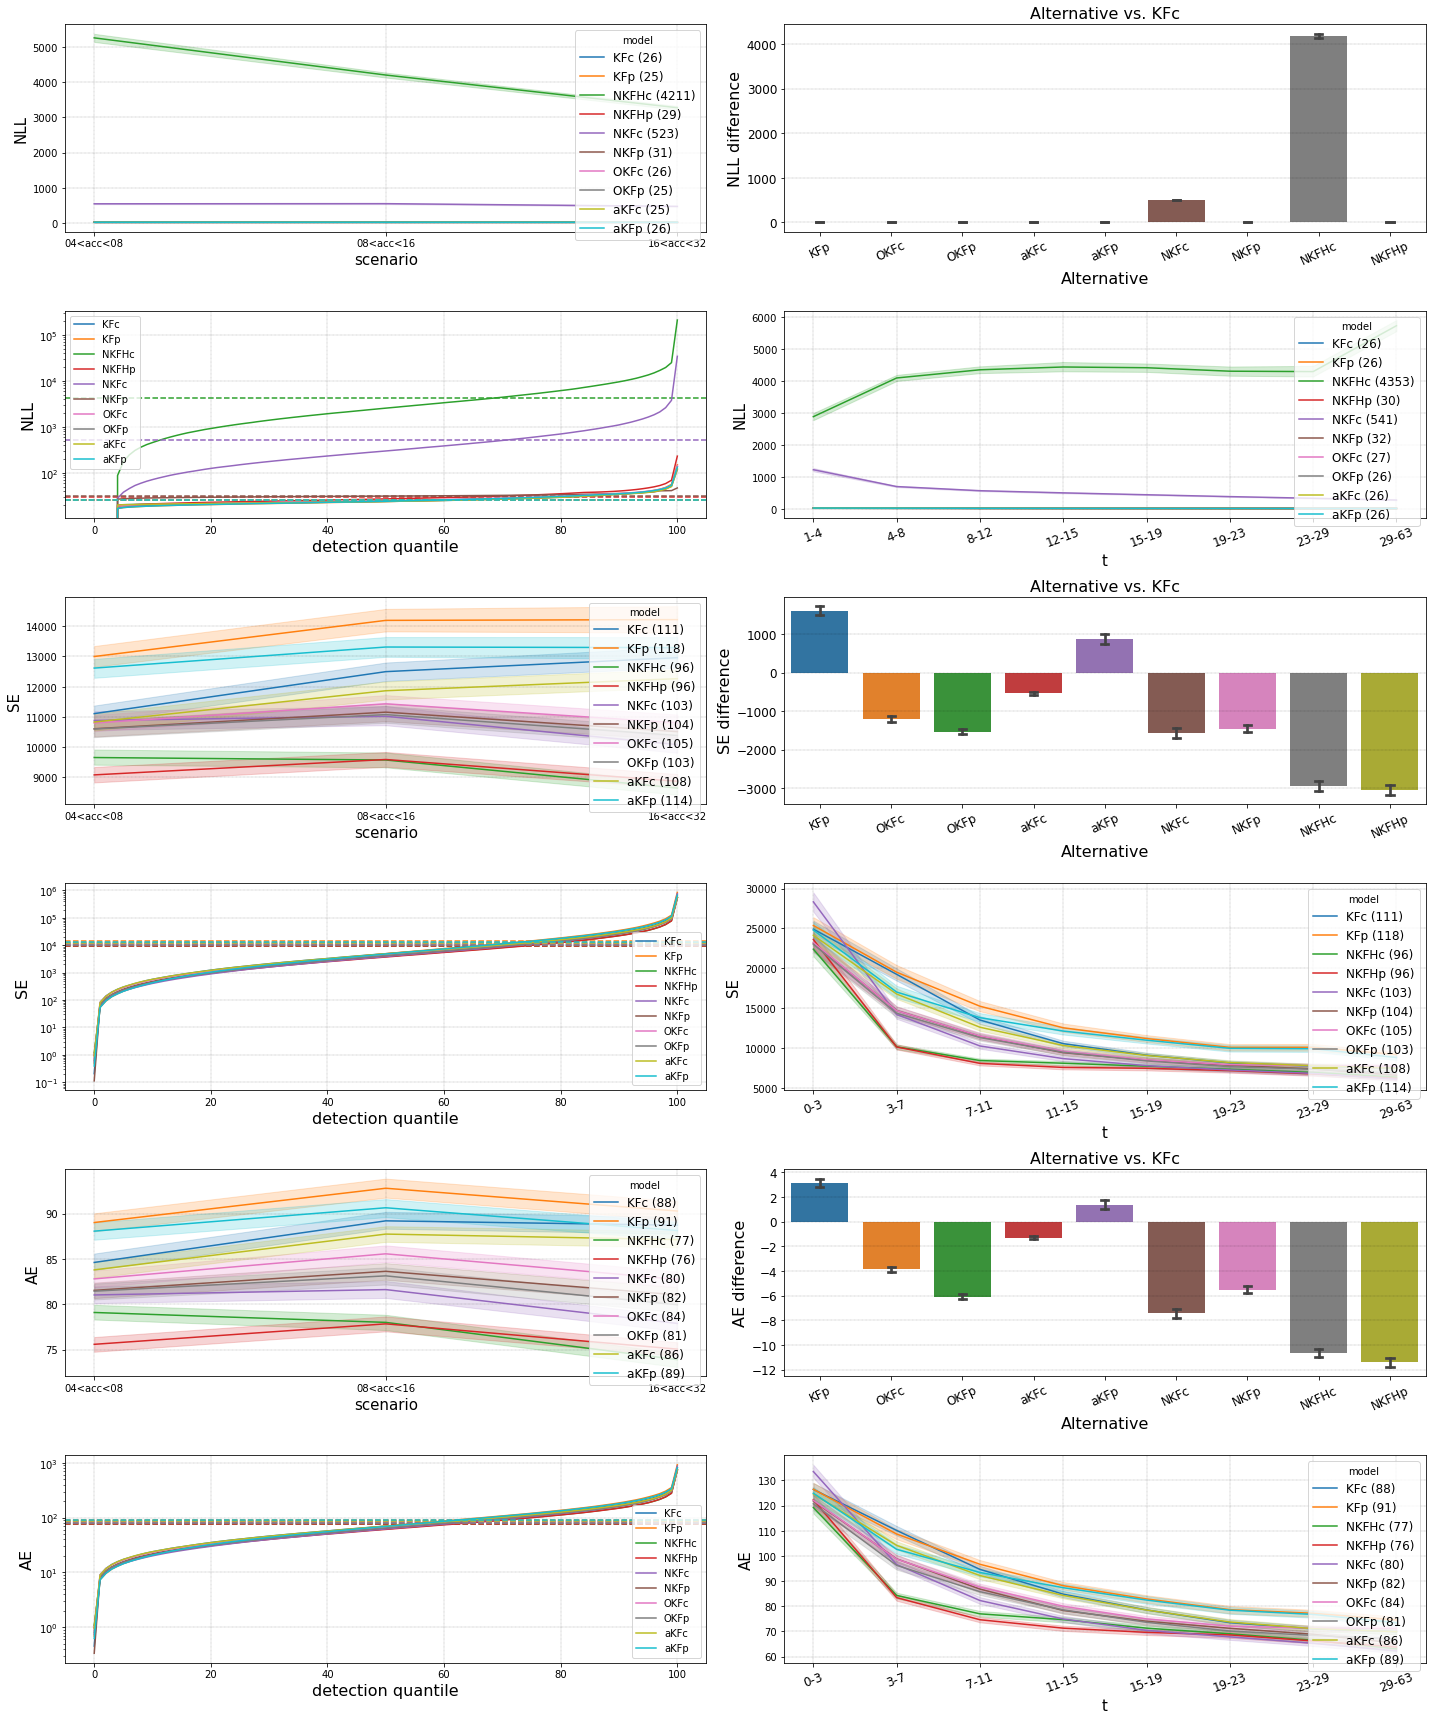

In [37]:
axs = PLAB.test_analysis(res, axargs=dict(W=2, axsize=(10,4)))

Results of KF,NKF,OKFp only (used for the original paper revision):

<ipython-input-38-f18be14e1105>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res2['model'] = [m[:-1] for m in res2.model]
/home/ido/code/Using_KF_the_Right_Way/utils.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ticks[1])
/home/ido/code/Using_KF_the_Right_Way/utils.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ticks[1])
/home/ido/code/Using_KF_the_Right_Way/utils.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ticks[1])


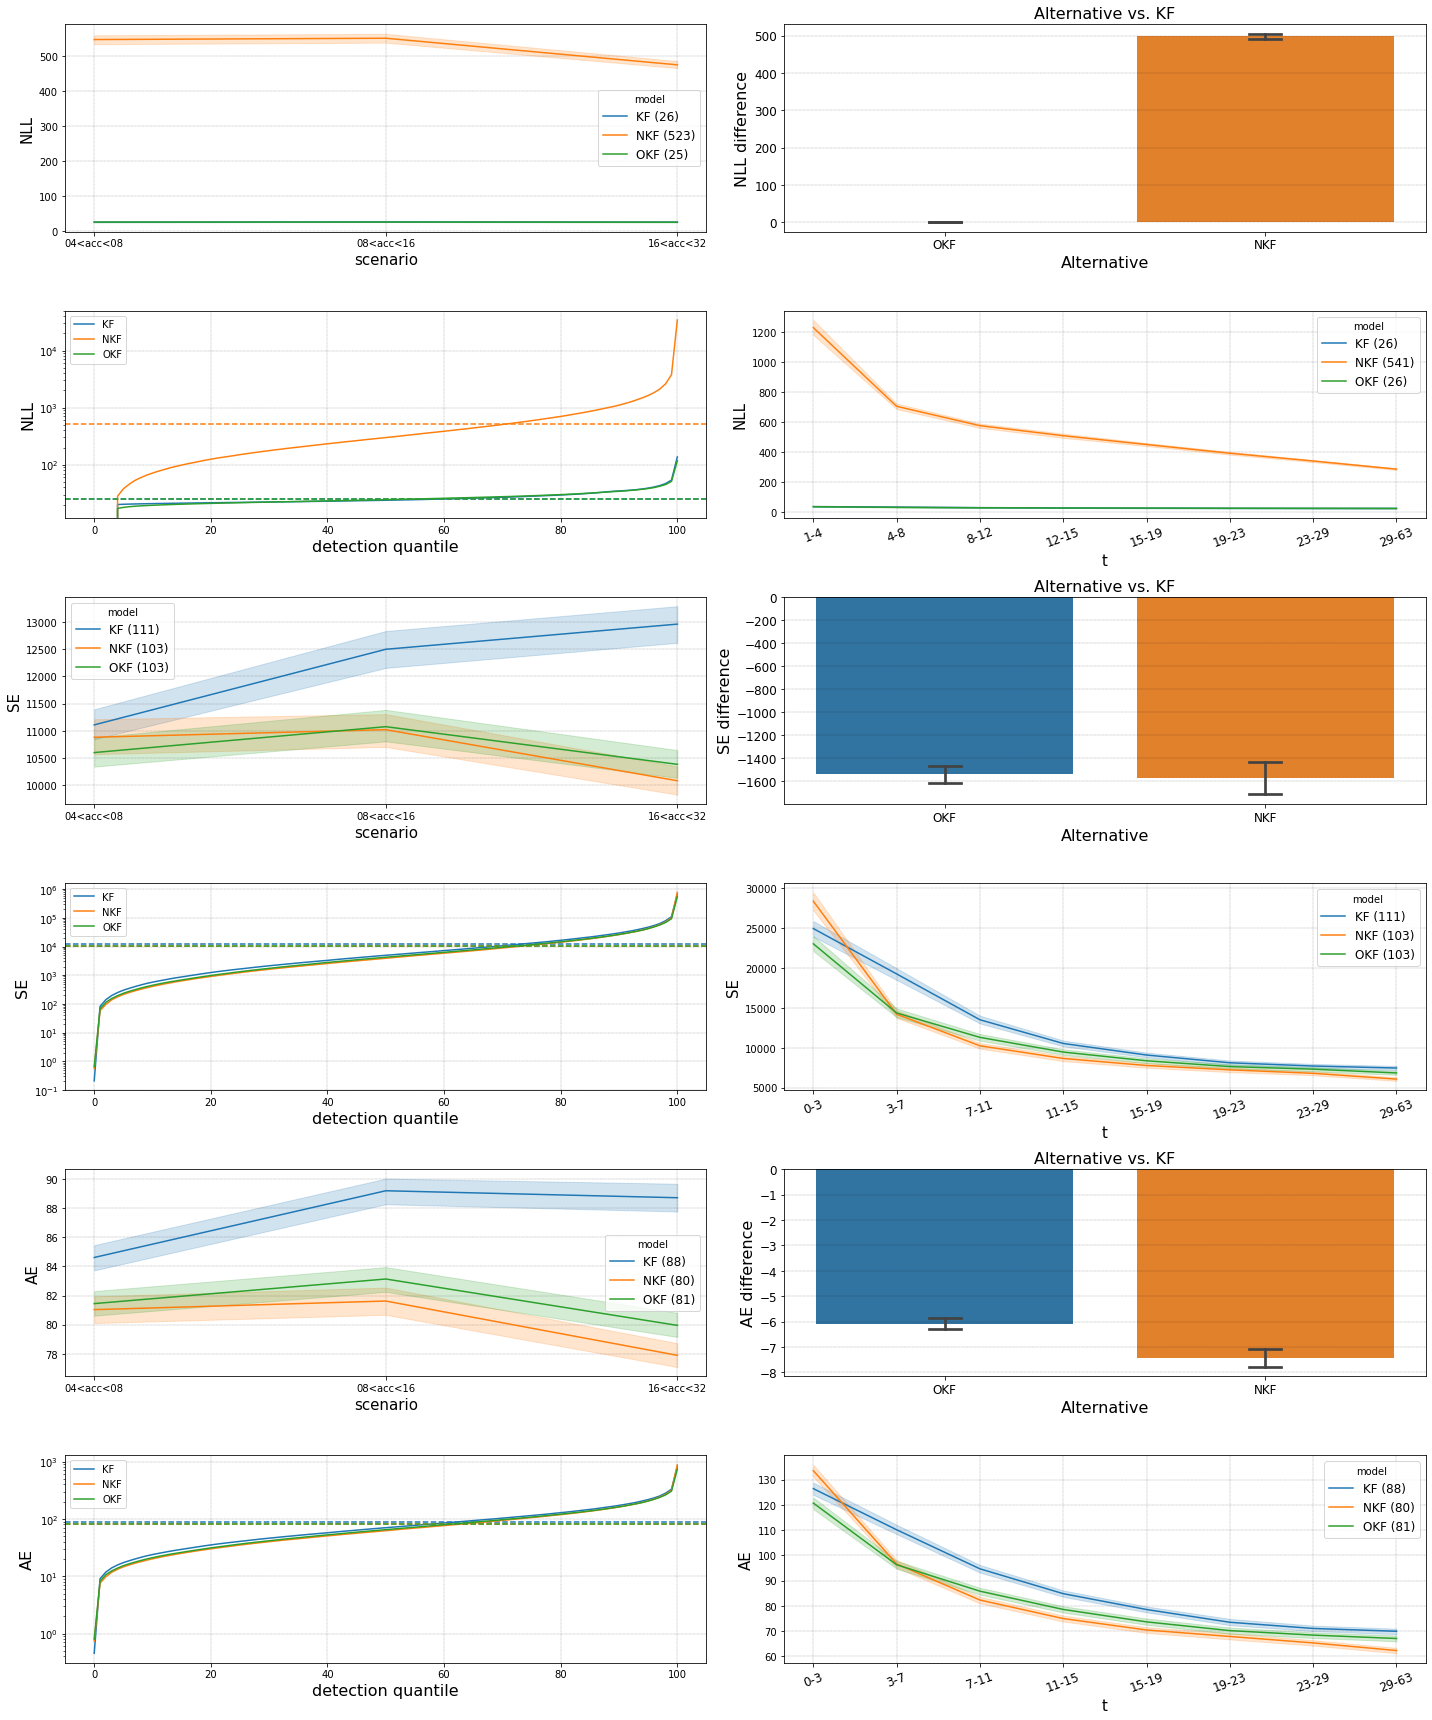

In [38]:
res2 = res[res.model.isin(('KFc','NKFp','OKFp'))]
res2['model'] = [m[:-1] for m in res2.model]
axs = PLAB.test_analysis(res2, axargs=dict(W=2, axsize=(10,4)))

#### For each model - results for the best variant among Cartesian/polar (selected using the validation data in the training summary above):

<ipython-input-39-fe2632a243a0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res2['model'] = [m[:-1] for m in res2.model]
/home/ido/code/Using_KF_the_Right_Way/utils.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ticks[1])
/home/ido/code/Using_KF_the_Right_Way/utils.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ticks[1])
/home/ido/code/Using_KF_the_Right_Way/utils.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ticks[1])


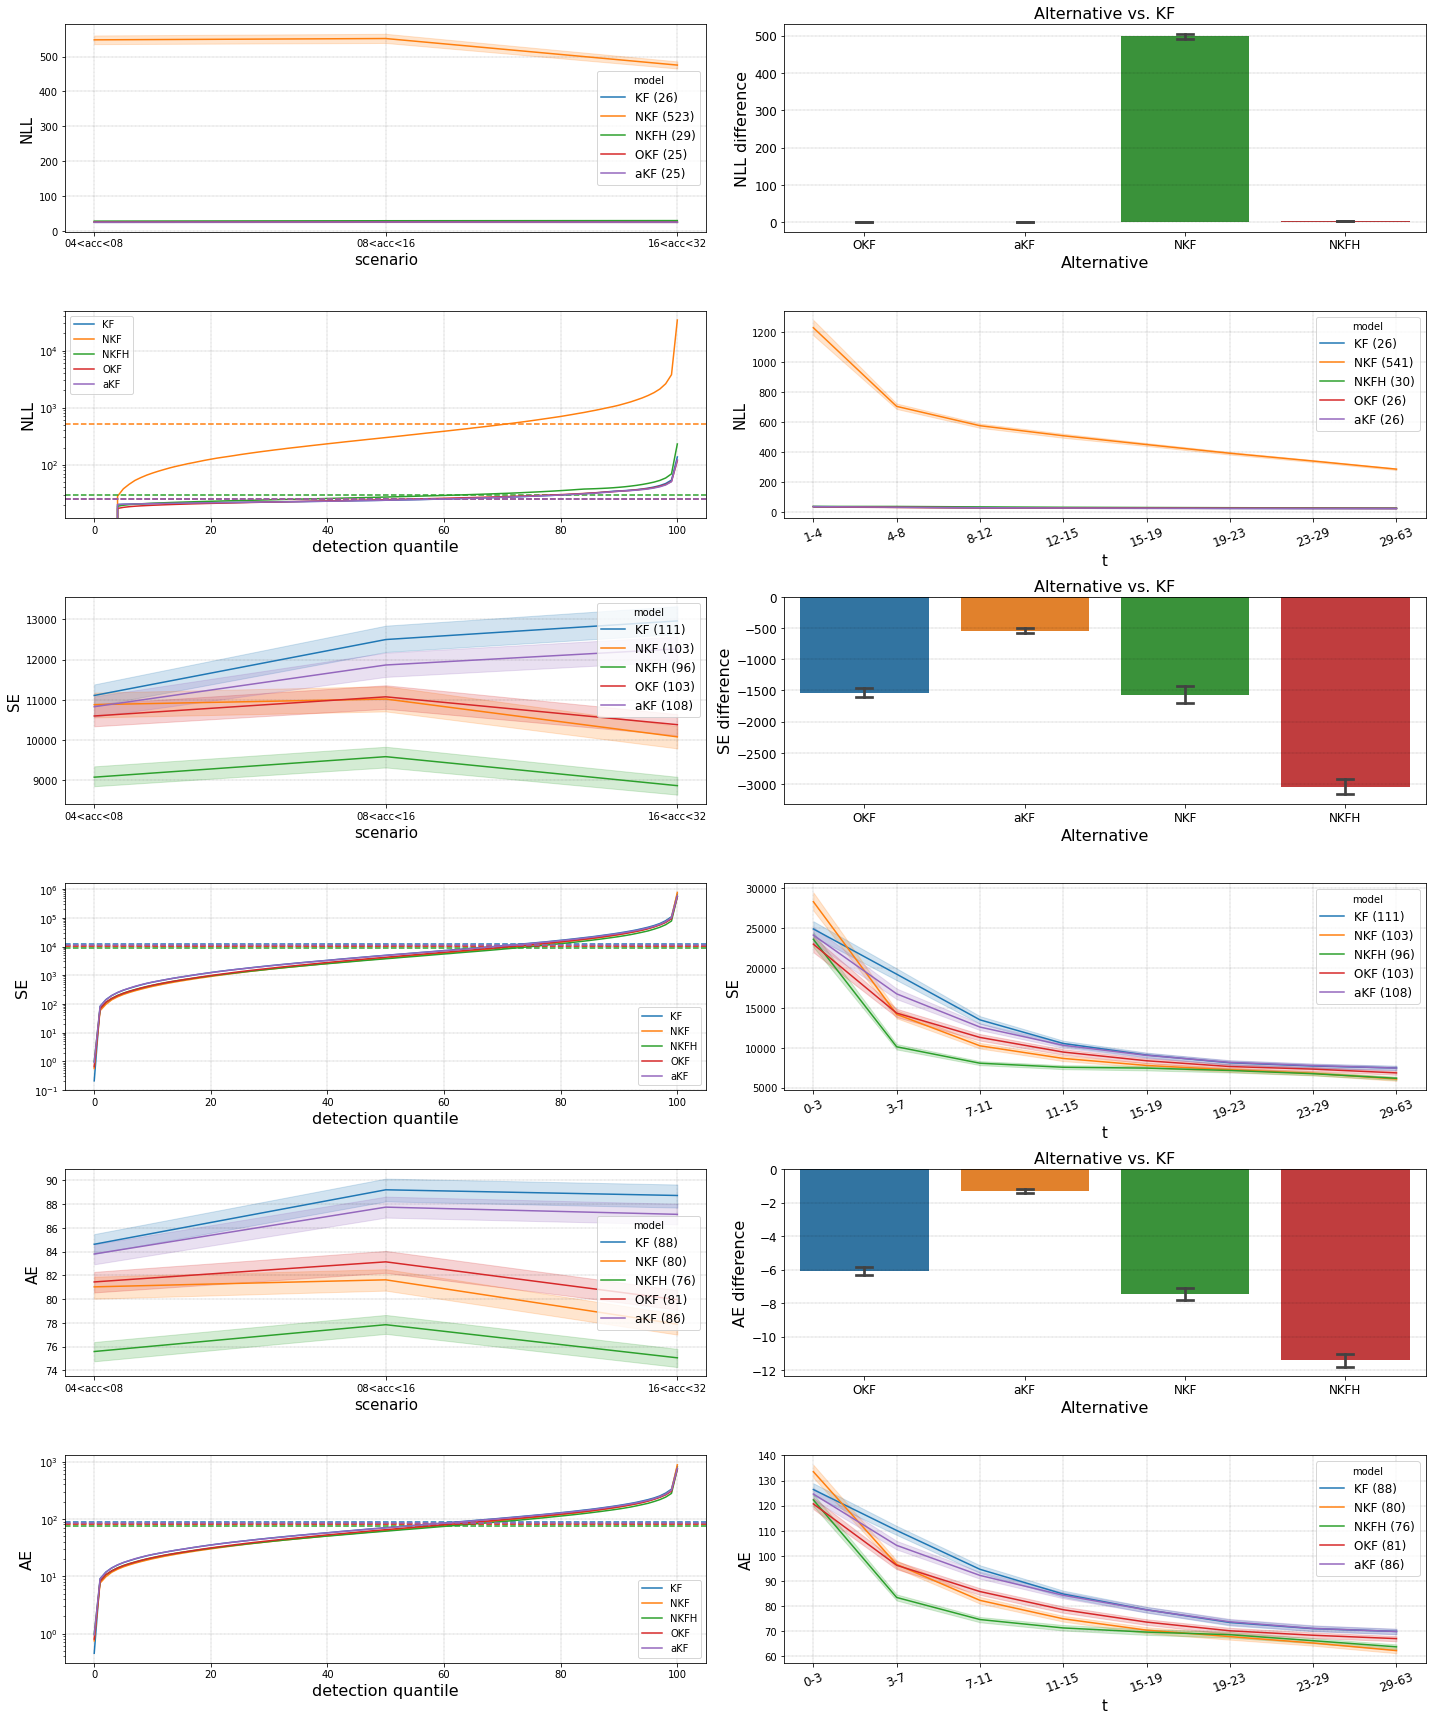

In [39]:
res2 = res[res.model.isin(('KFc','OKFp','aKFc','NKFp','NKFHp'))]
res2['model'] = [m[:-1] for m in res2.model]
axs = PLAB.test_analysis(res2, axargs=dict(W=2, axsize=(10,4)))

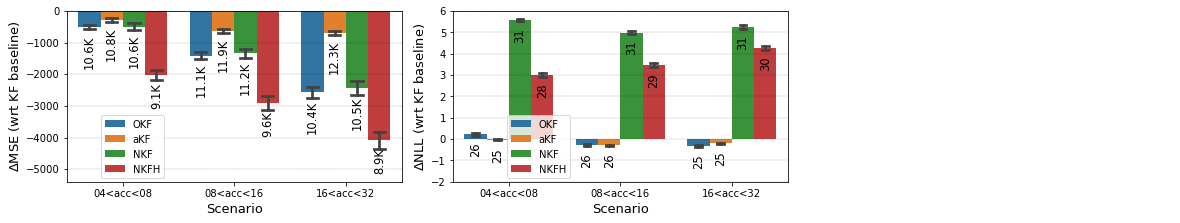

In [46]:
axs = utils.Axes(2, 3, (5.5,3.2))

res2 = res[res.model.isin(('KFc','OKFp','aKFc','NKFp','NKFHp'))].copy()
res2['model'] = [m[:-1] for m in res2.model]

res2['SE_difference'] = 0
for m in np.unique(res2.model):
    res2.loc[res2.model==m, 'SE_difference'] = res2.loc[res2.model==m, 'SE'].values - res2.loc[res2.model=='KF', 'SE'].values
ax = axs[0]
h = sns.barplot(data=res2[res2.model!='KF'], x='scenario', hue='model', y='SE_difference', ax=ax, ci=95, capsize=.1);
for i,(p,s) in enumerate(zip(h.patches, len(np.unique(res2.model))*list(np.unique(res2.scenario)))):
    lab = p.get_height() + res2.SE[(res2.model=='KF')&(res2.scenario==s)].mean()
    h.annotate(f'{lab/1000:.1f}K',
               (p.get_x() + p.get_width() / 2., p.get_height()), rotation=90,
               ha = 'center', va = 'top',  size=11.5, xytext = (0, -8),  textcoords = 'offset points')
ax.set_ylim((-5400,0))
ax.legend(loc=(0.1,0.02))
axs.labs(0, 'Scenario', '$\Delta$MSE (wrt KF baseline)', None, fontsize=13)

res2['NLL_difference'] = 0
for m in np.unique(res2.model):
    res2.loc[res2.model==m, 'NLL_difference'] = res2.loc[res2.model==m, 'NLL'].values - res2.loc[res2.model=='KF', 'NLL'].values
ax = axs[1]
h = sns.barplot(data=res2[res2.model!='KF'], x='scenario', hue='model', y='NLL_difference', ax=ax, ci=95, capsize=.06);
ymax = 6
for i,(p,s) in enumerate(zip(h.patches, len(np.unique(res2.model))*list(np.unique(res2.scenario)))):
    lab = p.get_height() + res2.NLL[(res2.model=='KF')&(res2.scenario==s)].mean()
    h.annotate(f'{lab:.0f}',
               (p.get_x() + p.get_width() / 2., min(p.get_height(),ymax)), rotation=90,
               ha = 'center', va = 'top',  size=11.5, xytext = (0, -8),  textcoords = 'offset points')
ax.set_ylim((-2,ymax))
ax.legend(loc=(0.16,0.02))
axs.labs(1, 'Scenario', '$\Delta$NLL (wrt KF baseline)', None, fontsize=13)

plt.tight_layout();
plt.savefig('outputs/NKF_Consta_paired_res.png', bbox_inches='tight');

TODO display results over a sample of targets (plot trajectories or show likelihood-colormap).